# PRUEBA TÉCNICA CIENTÍFICO DE DATOS NEQUI

#### Elaborado por:
Valentina Gómez Garzón

## Objetivo

Idear una solución para identificar transacciones que evidencian un comportamiento de Mala Practica Transaccional, empleando un producto de datos.
Una Mala Practica Transaccional es un comportamiento donde se evidencia un uso de los canales mal intencionado, para la prueba técnica nos centraremos en la práctica de Fraccionamiento Transaccional, esta mala práctica consiste en fraccionar una transacción en un número mayor de transacciones con menor monto que agrupadas suman el valor de la transacción original.

#### Características: 
Estas transacciones se caracterizan por estar en una misma ventana de tiempo que suele ser 24 horas y tienen como origen o destino la misma cuenta o cliente.

## Metodología

Por problemas de capacidad de memoria se escoge solo un dataset para el análisis y entrenamiento de modelos.
#####  Lenguaje de programación: Python.

Se usó Jupyter Notebook  que es una aplicación web que sirve a modo de puente constante entre el código y los textos explicativos. El programa se ejecuta desde la aplicación web cliente que funciona en cualquier navegador estándar. 

## INDICE

1. Librerías.
2. Lectura de los datos.
3. Variables.
4. Análisis descriptivo variables iniciales.
5. Agrupamiento y creación de variables.
6. Análisis Variable respuesta: Posible Fraude.
7. Transformación de datos.
8. Modelos.
            8.1 Random Forest
            8.2 Random Forest con class_weight='balanced_subsample
            8.3 Regresión logística con seleccion de variables
            8.4 Regresión logística con Class weighting (solucionaria el desbalanceo)
            8.5 Xgboost
            8.6 Xgboost con hiperparámetros
            8.7 Decision Tree
            8.8 Gradient Bosting
            8.9 Ada Boost
9. Análisis de errores.
10. Selección de mejor modelo.
11. Arquitectura del proceso.
12. Trabajos futuros.

## 1. Librerías

In [1]:
import pandas as pd
import datetime
import numpy as np  
import datetime as dt

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('ggplot')

# Modelamiento
# ==============================================================================
from sklearn.pipeline import Pipeline
import multiprocessing
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, StratifiedKFold
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector 
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_curve, auc, accuracy_score, plot_confusion_matrix, classification_report, f1_score
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import RFE, SelectKBest, f_classif,RFECV
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTENC


#formato números con dos decimales
pd.options.display.float_format = '{:.4f}'.format

## 2. Leer los datos

In [2]:
df1=pd.read_parquet('sample_data_0000_part_00.parquet')
df2=pd.read_parquet('sample_data_0001_part_00.parquet')
df3=pd.read_parquet('sample_data_0002_part_00.parquet')
df4=pd.read_parquet('sample_data_0003_part_00.parquet')
df5=pd.read_parquet('sample_data_0004_part_00.parquet')
df6=pd.read_parquet('sample_data_0005_part_00.parquet')
df7=pd.read_parquet('sample_data_0006_part_00.parquet')

In [3]:
base=pd.concat([df1,df2,df3,df4,df5,df6,df7])
#base=pd.concat([df1,df2,df3])

In [4]:
#base=df1.copy()

In [5]:
base=base.reset_index()
base.drop(['index'],axis=1,inplace=True)

In [6]:
base

,merchant_id,_id,subsidiary,transaction_date,account_number,user_id,transaction_amount,transaction_type
0,075d178871d8d48502bf1f54887e52fe,3aeb98f02b9fbf01cc14f1679b09d5e0,fb502e2ca32fb79609ca7514d41c02cd,2021-09-12 18:07:10,cc18c62a51b048ebf7e11ef8994c1ff3,d796d6838f4874508d5a7d1fd6fef607,59.44455012,CREDITO
1,075d178871d8d48502bf1f54887e52fe,dce1a8ee2b93dcf25a3ab04a7704004a,9dbcf12729217f1027caf6b1e7eb5728,2021-09-12 18:06:56,d8e0d4c8125577f5a3633dd6af140eaa,eb4464242fe2bb9b7fbf6d3d38474c1e,23.77782004,CREDITO
2,075d178871d8d48502bf1f54887e52fe,d4a6a637e49e790d5810a4abc5352c53,e3936fe59f0f400afa47802c0f4c2ba2,2021-09-12 18:06:37,d0d42a4eeb347c6492ef981985a47732,cbcf418306db3db0486c359b0f5b7ffa,35.66673007,CREDITO
3,075d178871d8d48502bf1f54887e52fe,46032962fab1112ffaa63276cc17b19e,40d92864e9f2bfb038a41804045cd700,2021-09-12 18:07:19,0863565298fcac1cde864beac71480c3,1053091431afaccf776a6aa7da47937f,10.70001902,CREDITO
4,075d178871d8d48502bf1f54887e52fe,4bd76c0db0a932fa5e7194c0eee85fd0,66c09ecb6efbff04e80f3f491801e371,2021-09-12 18:06:23,c5aaf5485c512e5b76bf6be7d736e9d0,ce1c4d09bf3df578d3b48ecc23cd201d,59.44455012,CREDITO
...,...,...,...,...,...,...,...,...
10758327,838a8fa992a4aa2fb5a0cf8b15b63755,3d48771f71045de6b05be3efb324da69,6cdb6692859b081ae1d3d4545704a2eb,2021-11-30 11:09:55,29fafc056c517c614ee0dd9a93f3bb28,8873621e306643ce037d16242933e70b,50.52786760,CREDITO
10758328,838a8fa992a4aa2fb5a0cf8b15b63755,324e4ad6686b4ad712ba0684325d0785,97cd34132a4ca71d06ea4f1f67d2b1f9,2021-11-30 15:50:53,bc1dffb06909d65a9425129db77bf020,2fbe8b4e11b5477f8b8a4e64d2cedea8,19.02225603,CREDITO
10758329,838a8fa992a4aa2fb5a0cf8b15b63755,63ad83d5ca20d4a7840c6b437e22972c,a872f515f65d80bfd899b350054dd457,2021-11-30 14:13:41,d7768104183b80a31919012e1e48e412,257200e80942edf1888a93ead4125dcb,5.94445501,CREDITO
10758330,838a8fa992a4aa2fb5a0cf8b15b63755,f73f9e553f3b272ea7fdc71ab92c9e02,a492a94a8178125678ea68bbc5d3ee53,2021-11-30 15:08:41,a1f2f2049df145c8380830a31f1e2197,2fb05d8d81622621e9a20ff8a73c825f,11.88891002,CREDITO


## 3. Variables

 * _id: Identificador único del registro
 * merchant_id: Código único del Comercio o aliado.
 * subsidiary: Código unico de la sede o sucursal.
 * transaction_date: Fecha de contabilización de la transacción en el core Financiero.
 * account_number: numero único de cuenta
 * user_id: Código único del usuario dueño de la cuenta desde donde se registran las transacciones.
 * transaction_amount: Monto de la transaction en moneda ficticia.
 * transaction_type: Naturaleza de la transacción valores (DEBITO o CREDITO)

In [7]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10758332 entries, 0 to 10758331
Data columns (total 8 columns):
 #   Column              Dtype         
---  ------              -----         
 0   merchant_id         object        
 1   _id                 object        
 2   subsidiary          object        
 3   transaction_date    datetime64[ns]
 4   account_number      object        
 5   user_id             object        
 6   transaction_amount  object        
 7   transaction_type    object        
dtypes: datetime64[ns](1), object(7)
memory usage: 656.6+ MB


Cambio de tipo de datos para monto (transaction_amount)

In [8]:
base['transaction_amount']=base['transaction_amount'].astype(float)

Cambio tipo de dato de la fecha (transaction_date)

In [9]:
base['transaction_date']=pd.to_datetime(base['transaction_date'],format="%Y-%m-%d %H:%M:%S")

## 4. Análisis descriptivo variables iniciales

In [10]:
base.isnull().sum()
#no existen datos nulos

merchant_id           0
_id                   0
subsidiary            0
transaction_date      0
account_number        0
user_id               0
transaction_amount    0
transaction_type      0
dtype: int64

In [11]:
base.describe()

,transaction_amount
count,10758332.0000
mean,190.9201
std,240.3924
min,5.9445
25%,35.6667
50%,107.0002
75%,237.7782
max,3210.0057


In [12]:
#Fecha
base['transaction_date'].describe()

count                10758332
unique                7615469
top       2021-06-21 14:53:30
freq                       30
first     2021-01-01 00:02:23
last      2021-11-30 23:59:53
Name: transaction_date, dtype: object

In [13]:
base['transaction_date'].max()

Timestamp('2021-11-30 23:59:53')

Distribución monto

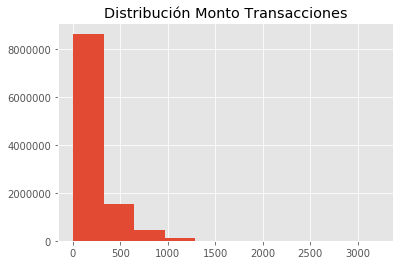

In [14]:
base['transaction_amount'].hist()
plt.title('Distribución Monto Transacciones')
plt.show()

Monto diario

In [15]:
monto_diario=base.groupby([pd.Grouper(key='transaction_date',freq='D')]).agg({'transaction_amount':'sum'})

In [16]:
monto_diario.head()

,transaction_amount
transaction_date,
2021-01-01,732404.3406
2021-01-02,2521971.3559
2021-01-03,1958082.7622
2021-01-04,5005693.0555
2021-01-05,4823710.6570


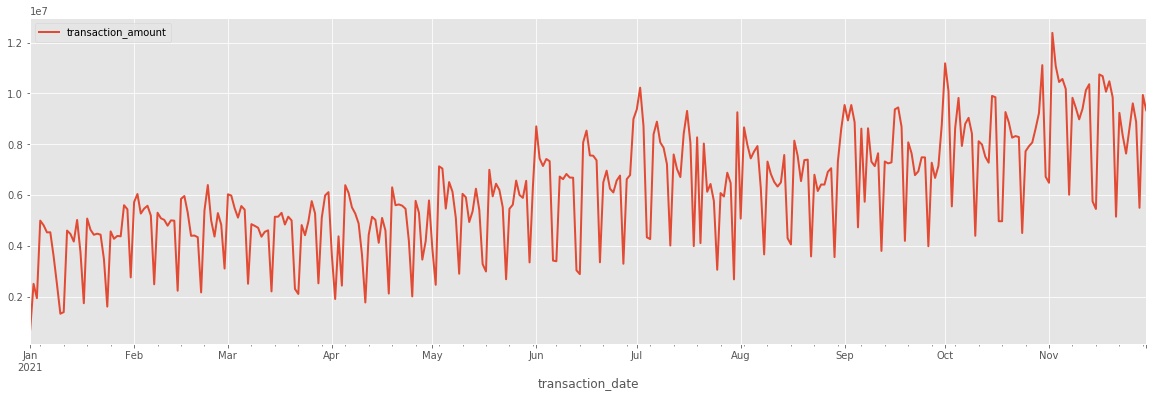

In [17]:
monto_diario.plot.line(y='transaction_amount',figsize=(20,6),lw=2)

Transacciones diarias

In [18]:
cantidad_diaria=base.groupby([pd.Grouper(key='transaction_date',freq='D')]).agg({'_id':'count'}).rename(columns={'_id':'cantidad'})

In [19]:
cantidad_diaria.head()

,cantidad
transaction_date,
2021-01-01,9069
2021-01-02,19767
2021-01-03,18668
2021-01-04,34443
2021-01-05,34397


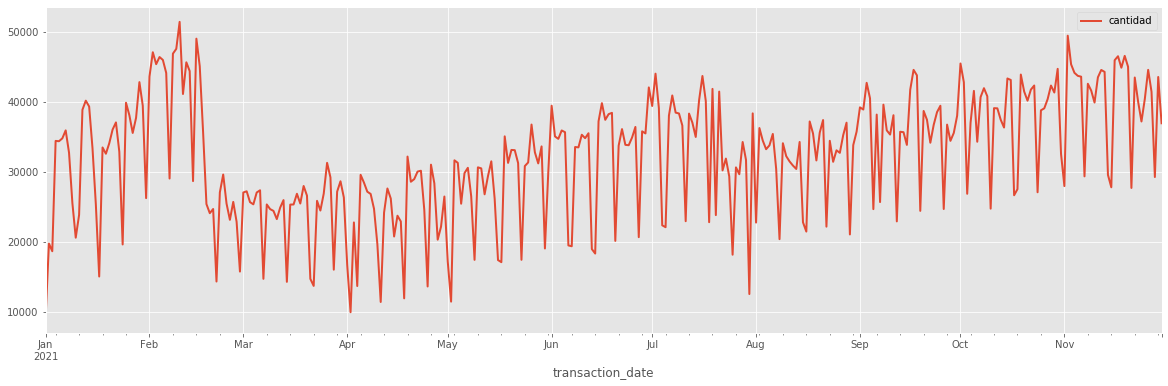

In [20]:
cantidad_diaria.plot.line(y='cantidad',figsize=(20,6),lw=2)

Análisis por días de la semana

In [21]:
cantidad_sem=cantidad_diaria.copy()
cantidad_sem['dia_semana'] = cantidad_sem.index.day_name(locale = 'Spanish')
cantidad_sem.sort_index(ascending = True)

,cantidad,dia_semana
transaction_date,,
2021-01-01,9069,Viernes
2021-01-02,19767,Sábado
2021-01-03,18668,Domingo
2021-01-04,34443,Lunes
2021-01-05,34397,Martes
...,...,...
2021-11-26,44600,Viernes
2021-11-27,41464,Sábado
2021-11-28,29279,Domingo


In [22]:
cantidad_semanal=cantidad_sem.groupby('dia_semana').agg({'cantidad':'sum'})
cantidad_semanal

,cantidad
dia_semana,
Domingo,1006902
Jueves,1602780
Lunes,1552282
Martes,1679645
Miércoles,1628432
Sábado,1632620
Viernes,1655671


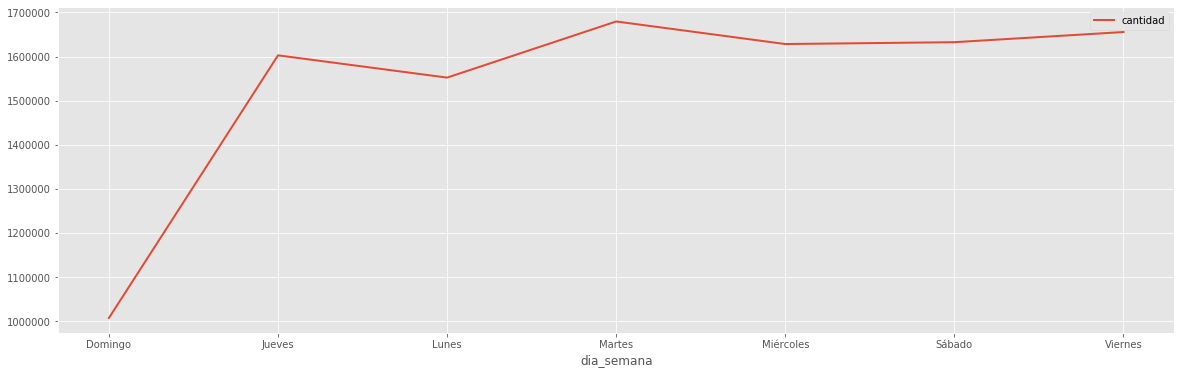

In [23]:
cantidad_semanal.plot.line(y='cantidad',figsize=(20,6),lw=2)

martes mayor flujo de transacciones, domingo menor flujo de transacciones

Análisis por mes

In [24]:
cantidad_mensual=base.groupby([pd.Grouper(key='transaction_date',freq='M')]).agg({'_id':'count'}).rename(columns={'_id':'cant'})
monto_mensual=base.groupby([pd.Grouper(key='transaction_date',freq='M')]).agg({'transaction_amount':'sum'}).rename(columns={'_id':'sum'})

In [25]:
cantidad_mensual

,cant
transaction_date,
2021-01-31,967975
2021-02-28,995965
2021-03-31,759632
2021-04-30,705216
2021-05-31,858202
2021-06-30,984388
2021-07-31,1034084
2021-08-31,979051
2021-09-30,1076633


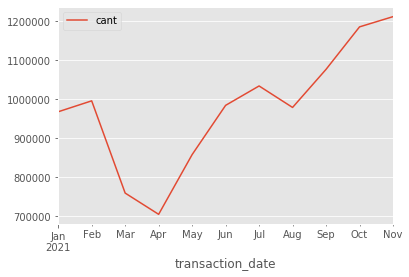

In [26]:
cantidad_mensual.plot.line(y='cant')

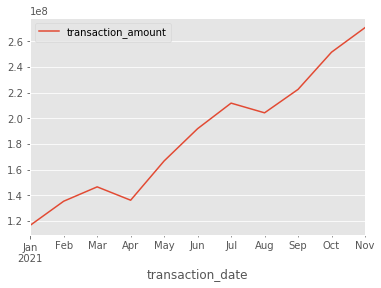

In [27]:
monto_mensual.plot.line(y='transaction_amount')

Variables categóricas

Código único del Comercio o aliado

In [28]:
base['merchant_id'].describe()

count                             10758332
unique                                   3
top       817d18cd3c31e40e9bff0566baae7758
freq                               7267200
Name: merchant_id, dtype: object

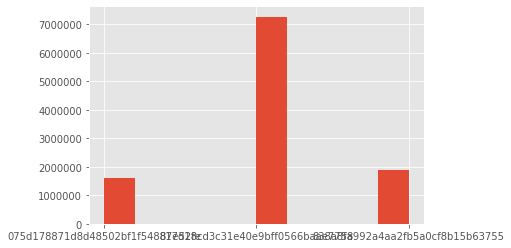

In [29]:
base['merchant_id'].hist()

In [30]:
base['subsidiary'].describe()

count                             10758332
unique                               16119
top       f54e0b6b32831a6307361ed959903e76
freq                                357502
Name: subsidiary, dtype: object

In [31]:
base['account_number'].describe()
#tenemos 1'958.741 clientes y 10'758.332 transacciones en todo el periodo

count                             10758332
unique                             1958741
top       bb43344022157cba434a58a212ed053f
freq                                  1100
Name: account_number, dtype: object

In [32]:
base['transaction_type'].describe()
#crédito y débito son los tipos de transaccion

count     10758332
unique           2
top         DEBITO
freq       8593233
Name: transaction_type, dtype: object

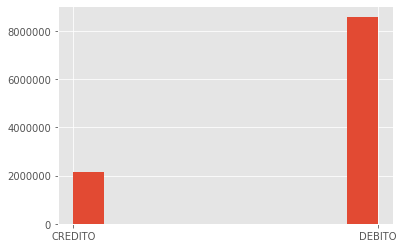

In [33]:
base['transaction_type'].hist()

Variables de tiempo

In [34]:
base['hora']=base['transaction_date'].dt.hour
base['dia']=base['transaction_date'].dt.day
base['dia_sem'] = base['transaction_date'].dt.day_name(locale = 'Spanish')
base['mes']=base['transaction_date'].dt.month
base['year']=base['transaction_date'].dt.year

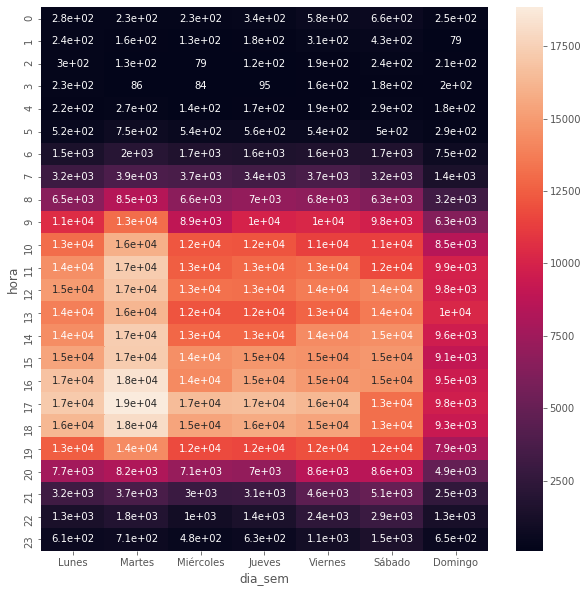

In [35]:
#Análisis ultimo mes
dense = base[base['mes']==11].groupby(['hora', 'dia_sem']).agg({'_id': 'count'}).reset_index()
vmin, vmax = dense['_id'].quantile([0, 1])
plt.figure(figsize = (10, 10))
sns.heatmap(dense.pivot(index = 'hora', columns = 'dia_sem', values = '_id')[['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado','Domingo']],
                                 annot = True, vmin = vmin, vmax = vmax)

PRUEBAS

In [36]:
#a=base_fin[base_fin['subsidiary']=='f54e0b6b32831a6307361ed959903e76']

In [37]:
#b=a[a['account_number']=='fc451c5e1737cf9d60fc983db47ff491']

In [38]:
#b=b[b['dia']==8]

In [39]:
#b=b[b['mes']==2]

In [40]:
#b

## 5. Agrupamiento y creación de variables

Para identificar la mala práctica transaccional de los corresponsales, se hace un agrupamiento que va contar por comercio, número de cuenta las transacciones que se realizaron en un lapso de 24 horas. Se hace un conteo para saber que cantidad se hicieron. 

In [41]:
base_fin=base.copy()

In [42]:
base_fin

,merchant_id,_id,subsidiary,transaction_date,account_number,user_id,transaction_amount,transaction_type,hora,dia,dia_sem,mes,year
0,075d178871d8d48502bf1f54887e52fe,3aeb98f02b9fbf01cc14f1679b09d5e0,fb502e2ca32fb79609ca7514d41c02cd,2021-09-12 18:07:10,cc18c62a51b048ebf7e11ef8994c1ff3,d796d6838f4874508d5a7d1fd6fef607,59.4446,CREDITO,18,12,Domingo,9,2021
1,075d178871d8d48502bf1f54887e52fe,dce1a8ee2b93dcf25a3ab04a7704004a,9dbcf12729217f1027caf6b1e7eb5728,2021-09-12 18:06:56,d8e0d4c8125577f5a3633dd6af140eaa,eb4464242fe2bb9b7fbf6d3d38474c1e,23.7778,CREDITO,18,12,Domingo,9,2021
2,075d178871d8d48502bf1f54887e52fe,d4a6a637e49e790d5810a4abc5352c53,e3936fe59f0f400afa47802c0f4c2ba2,2021-09-12 18:06:37,d0d42a4eeb347c6492ef981985a47732,cbcf418306db3db0486c359b0f5b7ffa,35.6667,CREDITO,18,12,Domingo,9,2021
3,075d178871d8d48502bf1f54887e52fe,46032962fab1112ffaa63276cc17b19e,40d92864e9f2bfb038a41804045cd700,2021-09-12 18:07:19,0863565298fcac1cde864beac71480c3,1053091431afaccf776a6aa7da47937f,10.7000,CREDITO,18,12,Domingo,9,2021
4,075d178871d8d48502bf1f54887e52fe,4bd76c0db0a932fa5e7194c0eee85fd0,66c09ecb6efbff04e80f3f491801e371,2021-09-12 18:06:23,c5aaf5485c512e5b76bf6be7d736e9d0,ce1c4d09bf3df578d3b48ecc23cd201d,59.4446,CREDITO,18,12,Domingo,9,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10758327,838a8fa992a4aa2fb5a0cf8b15b63755,3d48771f71045de6b05be3efb324da69,6cdb6692859b081ae1d3d4545704a2eb,2021-11-30 11:09:55,29fafc056c517c614ee0dd9a93f3bb28,8873621e306643ce037d16242933e70b,50.5279,CREDITO,11,30,Martes,11,2021
10758328,838a8fa992a4aa2fb5a0cf8b15b63755,324e4ad6686b4ad712ba0684325d0785,97cd34132a4ca71d06ea4f1f67d2b1f9,2021-11-30 15:50:53,bc1dffb06909d65a9425129db77bf020,2fbe8b4e11b5477f8b8a4e64d2cedea8,19.0223,CREDITO,15,30,Martes,11,2021
10758329,838a8fa992a4aa2fb5a0cf8b15b63755,63ad83d5ca20d4a7840c6b437e22972c,a872f515f65d80bfd899b350054dd457,2021-11-30 14:13:41,d7768104183b80a31919012e1e48e412,257200e80942edf1888a93ead4125dcb,5.9445,CREDITO,14,30,Martes,11,2021
10758330,838a8fa992a4aa2fb5a0cf8b15b63755,f73f9e553f3b272ea7fdc71ab92c9e02,a492a94a8178125678ea68bbc5d3ee53,2021-11-30 15:08:41,a1f2f2049df145c8380830a31f1e2197,2fb05d8d81622621e9a20ff8a73c825f,11.8889,CREDITO,15,30,Martes,11,2021


In [43]:
base_fin['sec']=base_fin.sort_values(by=['subsidiary','account_number','transaction_date'], ascending=True).\
                     groupby(['subsidiary','account_number','user_id',pd.Grouper(key='transaction_date',freq='24h')]).cumcount()+1

In [44]:
base_fin['mnt_real']=base_fin.groupby(['subsidiary','account_number', pd.Grouper(key='transaction_date',freq='24h')])['transaction_amount'].transform('sum')

In [45]:
base_fin['fraccionamientos']=base_fin.groupby(['subsidiary','account_number', pd.Grouper(key='transaction_date',freq='24h')])['transaction_date'].transform('count')

In [47]:
base_fin['cant_month_tran']=base_fin.groupby(['subsidiary','account_number','user_id'])['mes'].transform('nunique')

In [48]:
base_fin['trans_mes']=base_fin.groupby(['subsidiary','account_number','user_id','mes'])['transaction_amount'].transform('mean')

Se condiciona que si es mayor a 1 transacción por el mismo corresponsal y cuenta del cliente, se asume que podría ser fraude. 1: fraude 0: No fraude

In [49]:
base_fin['fraude']=base_fin['fraccionamientos'].apply(lambda x: 0 if x==1 else 1)

In [50]:
base_fin['mto_fracc']=base_fin['transaction_amount']/base_fin['mnt_real']

In [51]:
base_fin

,merchant_id,_id,subsidiary,transaction_date,account_number,user_id,transaction_amount,transaction_type,hora,dia,dia_sem,mes,year,sec,mnt_real,fraccionamientos,cant_month_tran,trans_mes,fraude,mto_fracc
0,075d178871d8d48502bf1f54887e52fe,3aeb98f02b9fbf01cc14f1679b09d5e0,fb502e2ca32fb79609ca7514d41c02cd,2021-09-12 18:07:10,cc18c62a51b048ebf7e11ef8994c1ff3,d796d6838f4874508d5a7d1fd6fef607,59.4446,CREDITO,18,12,Domingo,9,2021,1,59.4446,1,2,59.4446,0,1.0000
1,075d178871d8d48502bf1f54887e52fe,dce1a8ee2b93dcf25a3ab04a7704004a,9dbcf12729217f1027caf6b1e7eb5728,2021-09-12 18:06:56,d8e0d4c8125577f5a3633dd6af140eaa,eb4464242fe2bb9b7fbf6d3d38474c1e,23.7778,CREDITO,18,12,Domingo,9,2021,1,23.7778,1,2,23.7778,0,1.0000
2,075d178871d8d48502bf1f54887e52fe,d4a6a637e49e790d5810a4abc5352c53,e3936fe59f0f400afa47802c0f4c2ba2,2021-09-12 18:06:37,d0d42a4eeb347c6492ef981985a47732,cbcf418306db3db0486c359b0f5b7ffa,35.6667,CREDITO,18,12,Domingo,9,2021,1,35.6667,1,4,35.6667,0,1.0000
3,075d178871d8d48502bf1f54887e52fe,46032962fab1112ffaa63276cc17b19e,40d92864e9f2bfb038a41804045cd700,2021-09-12 18:07:19,0863565298fcac1cde864beac71480c3,1053091431afaccf776a6aa7da47937f,10.7000,CREDITO,18,12,Domingo,9,2021,1,10.7000,1,2,10.7000,0,1.0000
4,075d178871d8d48502bf1f54887e52fe,4bd76c0db0a932fa5e7194c0eee85fd0,66c09ecb6efbff04e80f3f491801e371,2021-09-12 18:06:23,c5aaf5485c512e5b76bf6be7d736e9d0,ce1c4d09bf3df578d3b48ecc23cd201d,59.4446,CREDITO,18,12,Domingo,9,2021,1,59.4446,1,1,59.4446,0,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10758327,838a8fa992a4aa2fb5a0cf8b15b63755,3d48771f71045de6b05be3efb324da69,6cdb6692859b081ae1d3d4545704a2eb,2021-11-30 11:09:55,29fafc056c517c614ee0dd9a93f3bb28,8873621e306643ce037d16242933e70b,50.5279,CREDITO,11,30,Martes,11,2021,1,50.5279,1,1,50.5279,0,1.0000
10758328,838a8fa992a4aa2fb5a0cf8b15b63755,324e4ad6686b4ad712ba0684325d0785,97cd34132a4ca71d06ea4f1f67d2b1f9,2021-11-30 15:50:53,bc1dffb06909d65a9425129db77bf020,2fbe8b4e11b5477f8b8a4e64d2cedea8,19.0223,CREDITO,15,30,Martes,11,2021,1,19.0223,1,1,19.0223,0,1.0000
10758329,838a8fa992a4aa2fb5a0cf8b15b63755,63ad83d5ca20d4a7840c6b437e22972c,a872f515f65d80bfd899b350054dd457,2021-11-30 14:13:41,d7768104183b80a31919012e1e48e412,257200e80942edf1888a93ead4125dcb,5.9445,CREDITO,14,30,Martes,11,2021,1,5.9445,1,1,5.9445,0,1.0000
10758330,838a8fa992a4aa2fb5a0cf8b15b63755,f73f9e553f3b272ea7fdc71ab92c9e02,a492a94a8178125678ea68bbc5d3ee53,2021-11-30 15:08:41,a1f2f2049df145c8380830a31f1e2197,2fb05d8d81622621e9a20ff8a73c825f,11.8889,CREDITO,15,30,Martes,11,2021,1,11.8889,1,1,11.8889,0,1.0000


In [52]:
base_fin.sort_values(['fraccionamientos'],ascending=False).head(10)
#maximos particionamientos

,merchant_id,_id,subsidiary,transaction_date,account_number,user_id,transaction_amount,transaction_type,hora,dia,dia_sem,mes,year,sec,mnt_real,fraccionamientos,cant_month_tran,trans_mes,fraude,mto_fracc
9143381,838a8fa992a4aa2fb5a0cf8b15b63755,48b75e81ea5aef537b07082e4ebff7c0,f54e0b6b32831a6307361ed959903e76,2021-02-03 14:21:54,aa560f02e10a63202228dcff6341e189,789c59c87fee33218ac916dbece2ed4e,5.9445,DEBITO,14,3,Miércoles,2,2021,92,1188.8910,200,2,5.9644,1,0.0050
9837022,838a8fa992a4aa2fb5a0cf8b15b63755,b0bec92ecadb4a883e32f56314f114e7,f54e0b6b32831a6307361ed959903e76,2021-02-08 16:34:34,fc451c5e1737cf9d60fc983db47ff491,7d046dfeb0ae6ebf51f3354a627a9a51,17.8334,DEBITO,16,8,Lunes,2,2021,114,1807.1143,200,1,9.0356,1,0.0099
9837034,838a8fa992a4aa2fb5a0cf8b15b63755,6f93e21d153525b635638300a348093c,f54e0b6b32831a6307361ed959903e76,2021-02-08 20:29:29,fc451c5e1737cf9d60fc983db47ff491,7d046dfeb0ae6ebf51f3354a627a9a51,5.9445,DEBITO,20,8,Lunes,2,2021,183,1807.1143,200,1,9.0356,1,0.0033
9837033,838a8fa992a4aa2fb5a0cf8b15b63755,4ee9febf44051a2f3296810f571819a3,f54e0b6b32831a6307361ed959903e76,2021-02-08 15:37:30,fc451c5e1737cf9d60fc983db47ff491,7d046dfeb0ae6ebf51f3354a627a9a51,17.8334,DEBITO,15,8,Lunes,2,2021,91,1807.1143,200,1,9.0356,1,0.0099
9837032,838a8fa992a4aa2fb5a0cf8b15b63755,84722da438bf38b212c2f5dfda78ce23,f54e0b6b32831a6307361ed959903e76,2021-02-08 18:51:51,fc451c5e1737cf9d60fc983db47ff491,7d046dfeb0ae6ebf51f3354a627a9a51,5.9445,DEBITO,18,8,Lunes,2,2021,153,1807.1143,200,1,9.0356,1,0.0033
9837031,838a8fa992a4aa2fb5a0cf8b15b63755,0de127c1af25fca9796bc6fda361b708,f54e0b6b32831a6307361ed959903e76,2021-02-08 13:23:49,fc451c5e1737cf9d60fc983db47ff491,7d046dfeb0ae6ebf51f3354a627a9a51,5.9445,DEBITO,13,8,Lunes,2,2021,76,1807.1143,200,1,9.0356,1,0.0033
9837030,838a8fa992a4aa2fb5a0cf8b15b63755,de9d803b71529632be35a0c7a374a4d7,f54e0b6b32831a6307361ed959903e76,2021-02-08 18:02:23,fc451c5e1737cf9d60fc983db47ff491,7d046dfeb0ae6ebf51f3354a627a9a51,17.8334,DEBITO,18,8,Lunes,2,2021,133,1807.1143,200,1,9.0356,1,0.0099
9837029,838a8fa992a4aa2fb5a0cf8b15b63755,b61172362b26a9de5b332a43344d1830,f54e0b6b32831a6307361ed959903e76,2021-02-08 20:28:02,fc451c5e1737cf9d60fc983db47ff491,7d046dfeb0ae6ebf51f3354a627a9a51,5.9445,DEBITO,20,8,Lunes,2,2021,182,1807.1143,200,1,9.0356,1,0.0033
9837028,838a8fa992a4aa2fb5a0cf8b15b63755,2954bf884c68335f07c818c436a2b7db,f54e0b6b32831a6307361ed959903e76,2021-02-08 13:19:18,fc451c5e1737cf9d60fc983db47ff491,7d046dfeb0ae6ebf51f3354a627a9a51,17.8334,DEBITO,13,8,Lunes,2,2021,75,1807.1143,200,1,9.0356,1,0.0099
9837027,838a8fa992a4aa2fb5a0cf8b15b63755,68cd15a27d09aa48eba306219b0dfd4f,f54e0b6b32831a6307361ed959903e76,2021-02-08 12:52:31,fc451c5e1737cf9d60fc983db47ff491,7d046dfeb0ae6ebf51f3354a627a9a51,17.8334,DEBITO,12,8,Lunes,2,2021,66,1807.1143,200,1,9.0356,1,0.0099


In [53]:
#castear fraude como categórico
base_fin['fraude']=base_fin['fraude'].astype(int)

## 6. Análisis Variable respuesta: Posible Fraude

In [54]:
base_fin['fraude'].describe()

count   10758332.0000
mean           0.1696
std            0.3753
min            0.0000
25%            0.0000
50%            0.0000
75%            0.0000
max            1.0000
Name: fraude, dtype: float64

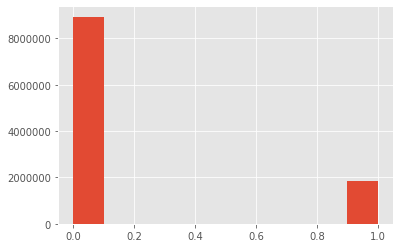

In [55]:
base_fin['fraude'].hist()

In [ ]:
a = sns.FacetGrid(base_fin, hue = 'fraude', aspect=4, palette="Set1" )
a.map(sns.kdeplot, 'transaction_amount', shade= True )
a.set(xlim=(0 , df['transaction_amount'].quantile(0.98)))
a.add_legend()

## 7. Transformación de datos

In [56]:
df=base_fin.copy()

Eliminación de variables que no voy a incluir

In [57]:
df.drop(['_id','subsidiary','account_number','user_id','year','mes','transaction_date','mnt_real','dia_sem','trans_mes','mto_fracc','cant_month_tran','fraccionamientos'],axis=1,inplace=True)

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10758332 entries, 0 to 10758331
Data columns (total 7 columns):
 #   Column              Dtype  
---  ------              -----  
 0   merchant_id         object 
 1   transaction_amount  float64
 2   transaction_type    object 
 3   hora                int64  
 4   dia                 int64  
 5   sec                 int64  
 6   fraude              int32  
dtypes: float64(1), int32(1), int64(3), object(2)
memory usage: 533.5+ MB


In [59]:
len((df.drop('fraude', axis = 'columns')).columns)

6

Partición en train y test

In [60]:
#70% entrenamiento 30% test
X_train, X_test, y_train, y_test = train_test_split(
                                        df.drop('fraude', axis = 'columns'),
                                        df['fraude'],
                                        train_size   = 0.7,
                                        random_state = 1234,
                                        stratify=df['fraude'],
                                        shuffle      = True
                                    )

#### Corrección de desbalanceos

In [61]:
df['fraude'].value_counts(normalize=True)

0   0.8304
1   0.1696
Name: fraude, dtype: float64

Para aumentar la representación de la clase minoritaria  se hace un oversampling. En este caso, el método consiste en samplear observaciones de la clase minoritaria con reposición.

In [64]:
oversampler=RandomOverSampler(sampling_strategy='minority');
X_train,y_train=oversampler.fit_resample(X_train,y_train);
print('Composición del training set:')
print(y_train.value_counts())
print('\nComposición del test set:')
print(y_test.value_counts())

El algoritmo SMOTE (Synthetic Minority Oversample) ofrece otra estrategia de oversampling, generando muestras simuladas de la clase minoritaria.

In [65]:
sm=SMOTENC(categorical_features=categorical_cols,k_neighbors=5,random_state=0)
X_train_sm,y_train_sm=sm.fit_resample(X_train,y_train)

##### Escalar Variables y encoder

Se crea pipeline de preprocesamiento escalando las variables numéricas y el encoder para las categóricas

In [66]:
# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )

# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]
                          )


preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, make_column_selector(dtype_include=np.number)),
                        ('cat', categorical_transformer, make_column_selector(dtype_include='object'))
                    ],
                    remainder='passthrough'
                )

Otra forma manual

In [67]:
#Otra forma getdummies
df_dummies = pd.get_dummies(df,drop_first=True)

In [68]:
#70% entrenamiento 30% test
X_train2, X_test2, y_train2, y_test2 = train_test_split(
                                        df_dummies.drop('fraude', axis = 'columns'),
                                        df_dummies['fraude'],
                                        train_size   = 0.7,
                                        random_state = 1234,
                                        stratify=df['fraude'],
                                        shuffle      = True
                                    )

In [70]:
standar_scaler = preprocessing.StandardScaler()

x_minmax = standar_scaler.fit_transform(X_train2)
X_train2=x_minmax
x_minmax1 = standar_scaler.fit_transform(X_test2)
X_test2=x_minmax1

## 8. Modelos

#### Random Forest

In [71]:
modeloRf=RandomForestClassifier()

In [72]:
pipe_rf = Pipeline([('preprocessing', preprocessor),
                 ('modelo', modeloRf)])

In [73]:
pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024484889088>),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000244848999C8>)])),
                ('modelo', RandomForestClassifier())])

In [74]:
y_pred_rf=pipe_rf.predict(X_test)

In [75]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96   2679959
           1       0.91      0.71      0.80    547541

    accuracy                           0.94   3227500
   macro avg       0.93      0.85      0.88   3227500
weighted avg       0.94      0.94      0.94   3227500



In [123]:
f1_rf = f1_score(y_test, y_pred_rf)

In [128]:
fpr, tpr, _ = roc_curve(y_test, y_pred_rf)
roc_auc_rf = auc(fpr, tpr)

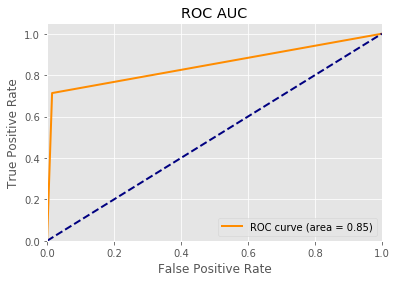

In [77]:
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC')
plt.legend(loc="lower right")
plt.show()

#### Random Forest con class_weight='balanced_subsample

In [141]:
modelorf_2=RandomForestClassifier(class_weight='balanced_subsample')

In [142]:
pipe_rf2 = Pipeline([('preprocessing', preprocessor),
                 ('modelo', modelorf_2)])

In [143]:
pipe_rf2.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024484889088>),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000244848999C8>)])),
                ('modelo',
                 RandomForestClassifier(class_weight='balanced_subsample'))])

In [144]:
y_pred_rf2=pipe_rf2.predict(X_test)

In [145]:
print(classification_report(y_test, y_pred_rf2))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95   2679959
           1       0.74      0.82      0.78    547541

    accuracy                           0.92   3227500
   macro avg       0.85      0.88      0.86   3227500
weighted avg       0.92      0.92      0.92   3227500



In [146]:
f1_rf2 = f1_score(y_test, y_pred_rf2)

In [147]:
fpr, tpr, _ = roc_curve(y_test, y_pred_rf2)
roc_auc_rf2 = auc(fpr, tpr)

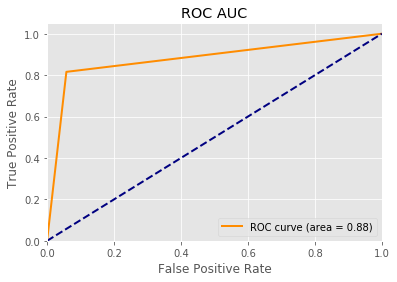

In [148]:
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc_rf2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC')
plt.legend(loc="lower right")
plt.show()

#### Regresión logística con seleccion de variables

Se hace una regresión logística con selección de variables por el método rfecv y validación cruzada para confirmar que variables optimizan dependiendo del scoring f1.

In [88]:
modeloRL=LogisticRegression()

In [89]:
kf = KFold(n_splits=3, shuffle = True)

In [90]:
selector = RFECV(modeloRL, step = 1, cv=kf, scoring = 'f1', verbose=2)

In [91]:
selector.fit(X_train2, y_train2)

Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.


RFECV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
      estimator=LogisticRegression(), scoring='f1', verbose=2)

In [93]:
selector

RFECV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
      estimator=LogisticRegression(), scoring='f1', verbose=2)

In [98]:
y_pred_RL1=selector.predict(X_test2)

In [99]:
print(classification_report(y_test, y_pred_RL1))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96   2679959
           1       1.00      0.63      0.77    547541

    accuracy                           0.94   3227500
   macro avg       0.96      0.82      0.87   3227500
weighted avg       0.94      0.94      0.93   3227500



In [124]:
f1_rl1 = f1_score(y_test, y_pred_RL1)

In [174]:
fpr, tpr, _ = roc_curve(y_test, y_pred_RL1)
roc_auc_rl1 = auc(fpr, tpr)

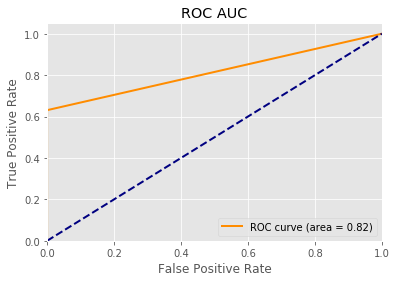

In [101]:
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc_rl1)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC')
plt.legend(loc="lower right")
plt.show()

#### Regresión logística con Class weighting (solucionaria el desbalanceo)

Otra técnica que podemos utilizar para corregir el desbalance de los datos es incorporar en la función de costos del algoritmo un mayor peso para los errores de entrenamiento cometidos sobre los puntos de la clase minoritaria. 

In [102]:
modelcw = LogisticRegressionCV(class_weight = 'balanced')

In [103]:
pipe_cw = Pipeline([('preprocessing', preprocessor), 
                 ('modelo', modelcw)])

In [104]:
pipe_cw.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024484889088>),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000244848999C8>)])),
                ('modelo', LogisticRegressionCV(class_weight='balanced'))])

In [105]:
y_pred_cw=pipe_cw.predict(X_test)

In [106]:
print(classification_report(y_test, y_pred_cw))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95   2679959
           1       0.74      0.73      0.74    547541

    accuracy                           0.91   3227500
   macro avg       0.84      0.84      0.84   3227500
weighted avg       0.91      0.91      0.91   3227500



In [125]:
f1_cw = f1_score(y_test, y_pred_cw)

In [176]:
fpr, tpr, _ = roc_curve(y_test, y_pred_cw)
roc_auc_cw = auc(fpr, tpr)

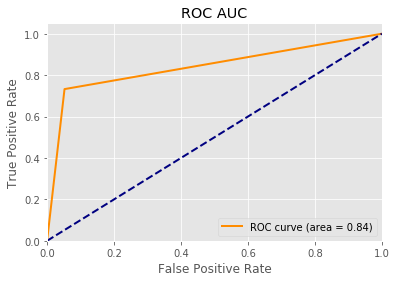

In [108]:
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc_cw)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC')
plt.legend(loc="lower right")
plt.show()

#### Xgboost

In [109]:
modeloXG=XGBClassifier()

In [110]:
pipe_xg = Pipeline([('preprocessing', preprocessor),
                 ('modelo', modeloXG)])

In [111]:
pipe_xg.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024484889088>),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_c...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_ra

In [112]:
y_pred_xg=pipe_xg.predict(X_test)

In [113]:
print(classification_report(y_test, y_pred_xg))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96   2679959
           1       0.91      0.71      0.80    547541

    accuracy                           0.94   3227500
   macro avg       0.93      0.85      0.88   3227500
weighted avg       0.94      0.94      0.94   3227500



In [126]:
f1_xg = f1_score(y_test, y_pred_xg)

In [178]:
fpr, tpr, _ = roc_curve(y_test, y_pred_xg)
roc_auc_xg = auc(fpr, tpr)

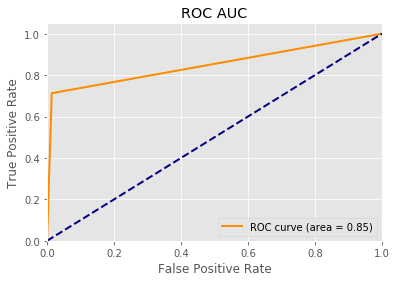

In [115]:
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc_xg)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC')
plt.legend(loc="lower right")
plt.show()

#### Xgboost con hiperparámetros

In [129]:
model_xg = XGBClassifier(n_jobs=-1, use_label_encoder=False)

In [130]:
cv = StratifiedKFold(n_splits=3, random_state=123, shuffle=True)

In [131]:
#parámetros
params = {  
    "n_estimators": [50,100],      # Number of boosted trees to fit.
    "max_depth": [1,2,3,4],            # Maximum tree depth for base learners.
    "learning_rate": [0.01, 0.1],      # Boosting learning rate (xgb’s “eta”)
}

In [132]:
xgb = GridSearchCV(model_xg, param_grid=params, cv=cv, verbose=1, n_jobs=-1,scoring='f1')

In [133]:
xgb.fit(X_train2,y_train2)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=123, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                

In [134]:
xgb.best_params_

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}

In [136]:
y_pred_xg1=xgb.predict(X_test2)

In [137]:
print(classification_report(y_test, y_pred_xg1))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96   2679959
           1       1.00      0.63      0.77    547541

    accuracy                           0.94   3227500
   macro avg       0.96      0.82      0.87   3227500
weighted avg       0.94      0.94      0.93   3227500



In [138]:
f1_xg1 = f1_score(y_test,  y_pred_xg1)

In [139]:
fpr, tpr, _ = roc_curve(y_test, y_pred_xg1)
roc_auc_xg1 = auc(fpr, tpr)

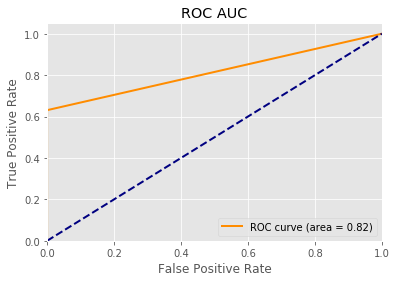

In [140]:
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc_xg1)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC')
plt.legend(loc="lower right")
plt.show()

#### Decision Tree

In [149]:
modelodt = DecisionTreeClassifier(random_state=1234)

In [150]:
pipe_dt = Pipeline([('preprocessing', preprocessor),
                 ('modelo', modelodt)])

In [151]:
pipe_dt.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024484889088>),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000244848999C8>)])),
                ('modelo', DecisionTreeClassifier(random_state=1234))])

In [152]:
y_pred_dt=pipe_dt.predict(X_test)

In [153]:
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96   2679959
           1       0.91      0.71      0.80    547541

    accuracy                           0.94   3227500
   macro avg       0.93      0.85      0.88   3227500
weighted avg       0.94      0.94      0.94   3227500



In [154]:
f1_dt = f1_score(y_test,  y_pred_dt)

In [155]:
fpr, tpr, _ = roc_curve(y_test, y_pred_dt)
roc_auc_dt = auc(fpr, tpr)

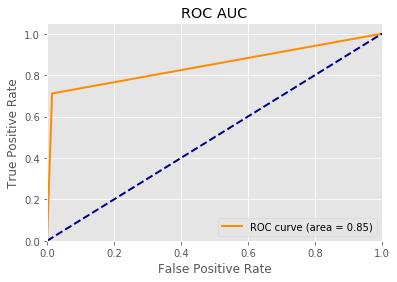

In [156]:
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc_dt)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC')
plt.legend(loc="lower right")
plt.show()

#### Gradient Bosting

In [157]:
modelogb=GradientBoostingClassifier()

In [158]:
pipe_gb = Pipeline([('preprocessing', preprocessor),
                 ('modelo', modelogb)])

In [159]:
pipe_gb.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024484889088>),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000244848999C8>)])),
                ('modelo', GradientBoostingClassifier())])

In [160]:
y_pred_gb=pipe_gb.predict(X_test)

In [161]:
print(classification_report(y_test, y_pred_gb))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96   2679959
           1       0.98      0.66      0.78    547541

    accuracy                           0.94   3227500
   macro avg       0.96      0.83      0.87   3227500
weighted avg       0.94      0.94      0.93   3227500



In [163]:
f1_gb = f1_score(y_test,  y_pred_gb)

In [162]:
fpr, tpr, _ = roc_curve(y_test, y_pred_gb)
roc_auc_gb = auc(fpr, tpr)

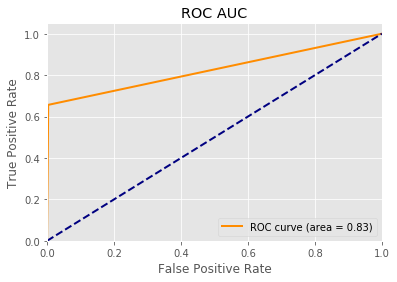

In [164]:
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc_gb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC')
plt.legend(loc="lower right")
plt.show()

#### Ada Boost

In [165]:
modeloada=AdaBoostClassifier()

In [166]:
pipe_ada = Pipeline([('preprocessing', preprocessor),
                 ('modelo', modeloada)])

In [167]:
pipe_ada.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024484889088>),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000244848999C8>)])),
                ('modelo', AdaBoostClassifier())])

In [168]:
y_pred_ada=pipe_ada.predict(X_test)

In [169]:
print(classification_report(y_test, y_pred_ada))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96   2679959
           1       0.94      0.68      0.79    547541

    accuracy                           0.94   3227500
   macro avg       0.94      0.84      0.88   3227500
weighted avg       0.94      0.94      0.93   3227500



In [170]:
f1_ada = f1_score(y_test,  y_pred_ada)

In [171]:
fpr, tpr, _ = roc_curve(y_test, y_pred_ada)
roc_auc_ada = auc(fpr, tpr)

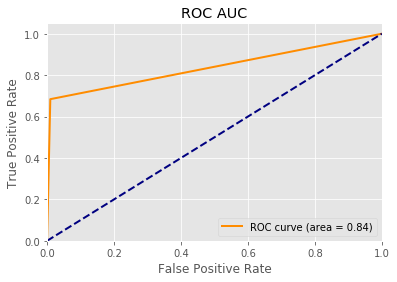

In [172]:
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc_ada)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC')
plt.legend(loc="lower right")
plt.show()

## 9. Análisis de errores 

Existen varias métricas para escoger un modelo, pero por su relevancia y análisis para este ejercicio se escogieron dos:
#####  F1
Accuracy se puede usar cuando las clase están balanceadeas, mientras que F1 score es una métrica mejor cuando hay clases desbalanceadas. Por esto, para este caso como tenemos un dataset desbalanceado, se usó esta métrica.


###### Curva ROC Y área AUC: 
Esta es una de las métricas más importantes utilizadas para medir el rendimiento de un modelo de clasificación. El área bajo la curva ROC se conoce como AUC, cuanto mayor es el valor de AUC mejor es el modelo. Cuanto más lejos esté la curva ROC de la línea diagonal (y = x), mejor será el modelo.
Así es como ROC-AUC nos permite evaluar el rendimiento de nuestro modelo, y nos proporciona un medio para seleccionar un modelo.

## 10. Selección de mejor modelo

Se realizaron varios modelos, unos con selección de variables, ajustes de hiperparámetros y solucionando el desbalanceo presente para este ejercio. Comparando cada una de las dos métricas seleccionadas (F1 y curva ROC-AUC), el modelo seleccionado fue:Random Forest con class Weight

Se analizaron las demás métricas pero estas dos serían las métricas para escoger entre todos los modelos.



A continuación se presenta los ranking de los modelos entrenados

In [179]:
A = [f1_rf,roc_auc_rf]
B = [f1_rf2,roc_auc_rf2]
C = [f1_rl1,roc_auc_rl1]
D = [f1_cw,roc_auc_cw]
F = [f1_xg,roc_auc_xg]
G = [f1_xg1,roc_auc_xg1]
H = [f1_dt,roc_auc_dt]
I = [f1_gb,roc_auc_gb]
J = [f1_ada,roc_auc_ada]

In [187]:
total = [A, B, C, D, F,G,H,I,J]
index =["Random Forest", "Random Forest con class_weight","Regresión logística select variables" ,"Regresión logística con Class weighting","Xgboost","Xgboost con hiperparámetros","Decision Tree","Gradient Bosting","Ada Boost"]
cols = ["F1", "ROC AUC"]
MedError= pd.DataFrame(total, columns=cols, index=index)
MedError.sort_values(['ROC AUC','F1',],ascending=False)

,F1,ROC AUC
Random Forest con class_weight,0.7777,0.8791
Xgboost,0.8004,0.8494
Random Forest,0.7986,0.8492
Decision Tree,0.7972,0.8482
Regresión logística con Class weighting,0.7371,0.8402
Ada Boost,0.7902,0.8371
Gradient Bosting,0.7849,0.8265
Regresión logística select variables,0.7736,0.8154
Xgboost con hiperparámetros,0.7736,0.8154


Debemos evitar el overfiting, conocido como el sobre ajuste, donde funciona excelente los datos como se entrenó el modelo pero a la hora de seleccionar otros datos, tiene un pésimo rendimiento. Se sacrifica rendimiento, pero se garantiza no caer en overfiting.

Recordamos que la forma de evitar el overfiting y logrando cada vez un mejor modelo es haciendo ajuste de hiperparámetros, selección de variables y solucionando los desbalanceos de clases, realizando pruebas de validación cruzada. 
El modelo elegido aunque los demás tenian un ROC AUC parecidos, se analizó que la curva que mejor se ajustaba fue el modelo elegido.

## 11. Arquitectura de proceso

La arquitectura del proceso  de entrenamiento:
    
    1. Captura de información directamente desde aws usando spark.
    2. Agrupamientos para seleccionar e idenficar los fraccionamientos transaccionales
    3. Realizar depuración, valores atípicos y molimiento de datos.
    4. división en datos de entrenamiento y test 70-20.
    5. Quitamos el desbalanceo de dos formas diferentes: con SMOTEC Y oversampling
    6. Gracias a el uso de pipline se tiene un proceso automatizado que consta de:
        * Preprocesamiento donde se hace la escalada de variables
        * Preprocesamiento para las variables categóricas para hacer el OneHotEncoder
        * Entrenamiento del modelo respectivo.
        * Ajuste de hiperparámetros.
    7. Con la muestra de testeo se sacan las métricas mas importantes para saber el rendimiento del modelo.
    8. Se selecciona el mejor modelo.
    9. Paso a producción.
    

La arquitectura del proceso ya en producción quedaría de la siguiente forma:
    1. Recolección de información en tiempo real, un día vecido.
    2. Realizar la predicción con el modelo seleccionado anteriormente.
    3. Entregar resultados.
    4. Se ingesta de nuevo la data y se hace un nuevo la arquitectura de entrenamiento para ir ajustando de nuevo el modelo.

Con esta arquitectura tendríamos un proceso que se podría ejecutar la predicción al cabo de 24 horas, donde se podría ir reentrenando, asegurando la captura de los fraccionamientos transaccionales.

## 12. Trabajo Futuro

* Para poder cargar todos los datos, se sugiera hacer la carga y el paso de modelo a spark. Spark ha establecido récords mundiales en cuanto a velocidades de procesamiento se refiere. Se pasaría toda la arquitectura y procesamiento a dicha herramienta. Además se podría explorar con el nuevo amazon SageMaker studio Lab para mejorar el rendimiento de la corrida de códigos.


* Trabajo próximo sería pensar un un forecast pero utilizando ya series de tiempo para pronosticar en promedio cuantos fraccionamientos transaccionales se podrían tener en un día sin haber corrido y los corresponsales mas prospensos a dicho fraude.


* Visualización donde se pueda identificar en dashboard los posibles fraccionamientos en tiempo real para la toma de decisiones, con métricas de procentaje.

